# Carvalho et al. Phys. Rev. Lett. 98 2007

In this reference the different unravelings are based in the invariance of the Lindblad equation under unitary and shift tranformation of the Lindblad operators $\hat{J}_k$, that is, in the fact that $\dot{\rho} = -i[H, \rho] + \mathcal{L}_k \rho$ is invariant under the following transformations:

$$ \hat{J}_{k} \rightarrow  \mu_k + U_{kl} \hat{J}_{l}$$ and $$ H \rightarrow H - \frac{i}{2} \sum_k (\mu_k^* \hat{J}_k - \mu_k \hat{J}^\dagger_k) $$ 

where $U$ is given by
$$U = \begin{pmatrix}\alpha e^{i \theta} & \beta e^{i\varphi}\\\ -\beta e^{-i \varphi} & \alpha e^{-i \theta}\end{pmatrix}.$$

We can get the same results by using the $\textsf{M}$-parametrization. For this case $\textsf{M}$ is given by

$$ \textsf{M} = \begin{pmatrix}\alpha e^{i \theta} & \beta e^{i\varphi} & 0 & 0\\\ -\beta e^{-i \varphi} & \alpha e^{-i \theta} & 0 & 0\end{pmatrix} $$

What follows is the reproduction of the main results of $\textit{Carvalho et al. Phys. Rev. Lett. 98 2007}$ with the use of the quantum jump scheme using its $\textsf{M}$-parametrization formulation.

In [1]:
import matplotlib.pyplot as plt

import numpy as np
from numba import jit

## Library
import qt_unraveling as qtr

In [2]:
## Analitical concurrence
@jit(nopython=True)
def C_psi(psi):
    op = np.kron(qtr.sigmay, qtr.sigmay)
    return np.linalg.norm(np.dot(psi, np.dot(op, psi)))

@jit(nopython=True)
def C_rho(rho):
    op = np.kron(qtr.sigmay, qtr.sigmay)
    rho_ = np.dot(op,np.dot(np.conjugate(rho), op))
    rhorho_ = np.dot(rho, rho_)
    
    evalues, evectors = np.linalg.eig(rhorho_)
    
    lambda_ = np.sqrt(np.abs(-1*np.sort(-1*np.real(evalues))))
    return np.max(np.array([0, np.abs(lambda_[0] - lambda_[1] - lambda_[2] - lambda_[3])]))

In [3]:
## Basis vectors
qub0 = np.array([0,1], dtype = np.complex128)
qub1 = np.array([1,0], dtype = np.complex128)

#### Parameters 
gamma = 0.2
t0 = 0
tf = 5
time_steps = 10000

## Time range
t = np.linspace(t0, tf, np.int32(time_steps))

### CNOT gate
The first example consists in a CNOT gate. In this case the optimal unraveling is given for $|\mu| = 0$, so no continuos limit is needed for this case.

In [4]:
## Initial state 
psi00_1 = np.sqrt(0.5)
psi01_1 = 0
psi10_1 = np.sqrt(0.5)
psi11_1 = 0
psi0_1 = (psi00_1*np.kron(qub0,qub0) + psi01_1*np.kron(qub0,qub1) + psi10_1*np.kron(qub1,qub0) + psi11_1*np.kron(qub1,qub1))

In [5]:
## Unraveling
##############################
ki1 = 0
ki2 = 0
##############################
alpha = 0.5
beta = np.sqrt(3)*0.5
##############################
phi = np.sqrt(0.5)*np.pi
theta = np.sqrt(0.5)*np.pi
##############################

## General jump operators
mu1 = 0*np.exp(1j*ki1)
mu2 = 0*np.exp(1j*ki2)

## M parametrization
m_matrix = np.zeros((2,4), dtype = np.complex128)
U = np.array([[alpha*np.exp(1j*theta),beta*np.exp(1j*phi)],[-beta*np.exp(-1j*phi), alpha*np.exp(-1j*theta)]], dtype = np.complex128)
m_matrix[0:2,2:4] = U

## Lindblad operators
J = np.sqrt(gamma)*np.array([np.kron(np.dot(qtr.sigmap, qtr.sigmam), np.eye(2)), np.kron(np.eye(2), np.dot(qtr.sigmap, qtr.sigmam))])

## CNOT Hamiltonian
HCNOT = 2*np.pi*np.eye(4) + (0.5*np.pi)*np.kron(np.dot(qtr.sigmap,qtr.sigmam),qtr.sigmax - np.eye(2))

In [6]:
## System definition
qubits_1_J = qtr.System(HCNOT, psi0_1, t, lindbladList = J, mMatrix = m_matrix)

In [7]:
%%time
## Trajectories ensemble
n_traj = 1
coherent_fields = np.array([mu1, mu1, mu2, mu2], dtype=np.complex128)
rho_average = qubits_1_J.jumpRhoTrajectory(coherent_fields=coherent_fields)

CPU times: user 395 ms, sys: 2.91 ms, total: 398 ms
Wall time: 403 ms


In [8]:
%%time
## Trajectories ensemble
n_traj = 1
coherent_fields = np.array([mu1, mu1, mu2, mu2], dtype=np.complex128)
rho_average = qubits_1_J.jumpRhoEnsemble(n_traj, coherent_fields=coherent_fields)

CPU times: user 49.8 ms, sys: 80.4 ms, total: 130 ms
Wall time: 623 ms


In [9]:
lind_evo = qubits_1_J.lindbladAnalitical()

In [10]:
%%time
########################################################
C_vec = []
C_analitical = []
for it in range(time_steps):
    ########################################################
    ## Avarage concurrence
    ########################################################
    C_aux = 0
    for n in range(n_traj):
        C_aux += (1/n_traj)*C_rho(rho_average[n][it])
    C_vec.append(C_aux)
    ########################################################
    ## Analitical concurrence
    ########################################################
    C_analitical.append(C_rho(lind_evo[it]))
    ########################################################

/tmp/ipykernel_49741/4270392434.py:11: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (array(complex128, 2d, A), array(complex128, 2d, C))
  rhorho_ = np.dot(rho, rho_)


CPU times: user 5.15 s, sys: 70.4 ms, total: 5.22 s
Wall time: 4.99 s


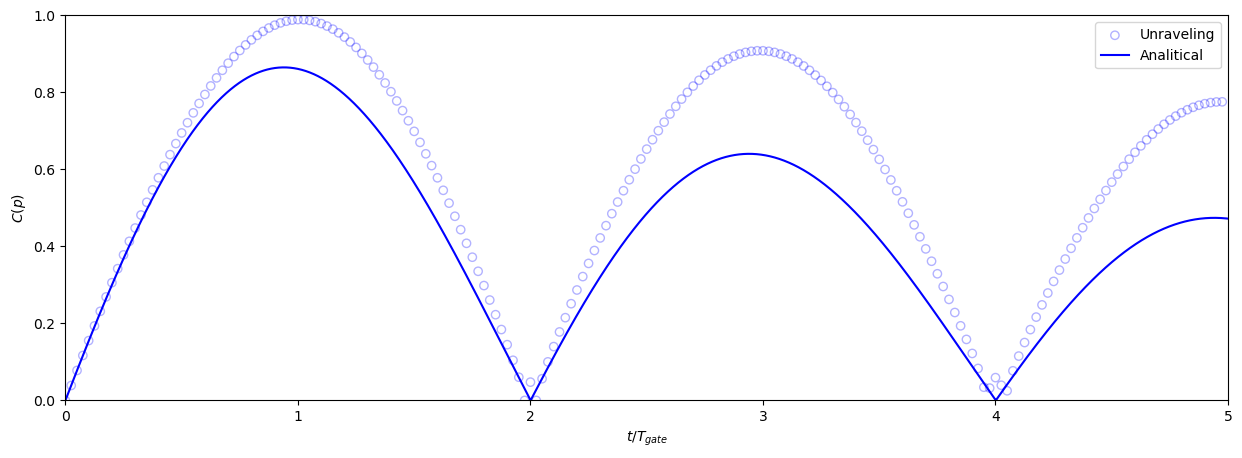

In [11]:
## Time scaling
T_gate = 1/(5*gamma)
gt = gamma*t

fig, ax = plt.subplots()
fig.set_size_inches(w=15, h=5)

# Plot
ax.set_ylim(0,1)
ax.set_xlim(0,5)

ax.scatter((t/T_gate)[::50], C_vec[::50], label = r'Unraveling', facecolors='none', edgecolors='b', alpha=0.3)

#plt.plot((t/T_gate)[::10], C_vec[::10])
ax.plot(t/T_gate, C_analitical, label = r'Analitical', color = 'b')

ax.set_xlabel(r'$t/T_{gate}$')
ax.set_ylabel(r'$C(p)$')
ax.legend()
plt.show()

### Frozen dynamics

The second example consists on a frozen system ($H = 0$). Unlike the previous case, an homodyne type detection leads to an optimal unraveling. As stated in the reference, $|\mu| \rightarrow \infty$ (that is equivalent to the use of the diffusive unraveling scheme) will converge to the analitical concurence.

In [12]:
## First initial state 
psi00_1 = np.sqrt(0.5)
psi01_1 = 0
psi10_1 = 0
psi11_1 = np.sqrt(0.5)

## Second initial state
psi00_2 = np.sqrt(1/8)
psi01_2 = 0
psi10_2 = 0
psi11_2 = np.sqrt(7/8)

## ki angle
ki_1 = 0.5*(np.angle((psi11_1**2)/(psi00_1*psi11_1 - psi01_1*psi10_1)) - 0.5*np.pi)
ki_2 = 0.5*(np.angle((psi11_2**2)/(psi00_2*psi11_2 - psi01_2*psi10_2)) - 0.5*np.pi)

## Intial states
psi0_1 = (psi00_1*np.kron(qub0,qub0) + psi01_1*np.kron(qub0,qub1) + psi10_1*np.kron(qub1,qub0) + psi11_1*np.kron(qub1,qub1))
psi0_2 = (psi00_2*np.kron(qub0,qub0) + psi01_2*np.kron(qub0,qub1) + psi10_2*np.kron(qub1,qub0) + psi11_2*np.kron(qub1,qub1))

## Jump operators
J = np.array([np.sqrt(gamma)*np.kron(qtr.sigmam, np.eye(2)), 
                     np.sqrt(gamma)*np.kron(np.eye(2),qtr.sigmam)], dtype=np.complex128)

## Hamiltonian
H_FROZEN = np.zeros((4,4), dtype = np.complex128)

## Class objects
############################
ki_1 = 0
ki_2 = 0.5*np.pi
phi1 = ki_1 - ki_1
theta1 = ki_2 - ki_1
phi2 = ki_1 - ki_2
theta2 = ki_2 - ki_2
############################
alpha = np.sqrt(0.5)
beta = np.sqrt(0.5)
############################
m_matrix = np.zeros((2,4), dtype = np.complex128)
U = np.array([[alpha*np.exp(1j*theta1),beta*np.exp(1j*phi1)],[-beta*np.exp(-1j*phi2), alpha*np.exp(-1j*theta2)]], dtype = np.complex128)
m_matrix[0:2,0:2] = U
############################
mu1_1 = 3*np.exp(1j*0*ki_1)
mu2_1  = 3*np.exp(1j*0*ki_1)
mu1_2 = 3*np.exp(1j*0*ki_2)
mu2_2  = 3*np.exp(1j*0*ki_2)
############################
qubits_1_J = qtr.System(H_FROZEN, psi0_1, t, lindbladList = J, mMatrix = m_matrix)
qubits_2_J = qtr.System(H_FROZEN, psi0_2, t, lindbladList = J, mMatrix = m_matrix)

The $\textsf{M}$ matrix that corresponds to the optimal unraveling  is given by

In [13]:
print(repr(np.round(qubits_1_J.M_rep)))

array([[ 0.+1.j,  1.+0.j,  0.+0.j,  0.+0.j],
       [-0.-1.j,  1.+0.j,  0.+0.j,  0.+0.j]])


The above $\textsf{M}$ matrix parametrizes a homodyne detection of the effective operators $J_2 + i J_1$ and $J_2 - i J_1$. It's quite interesting to note that this $\textsf{M}$ matrix for the optimal unraveling resembles the one found in $\textit{Viviescas Phys. Rev. Lett. 105 2010}$, which corresponds to

$$ \textsf{M} = \frac{e^{-i \theta_{opt}}}{\sqrt{2}} \begin{pmatrix} i & 1 & i & 1\\\ -i & 1 & -i& 1\end{pmatrix} $$

and parametrizes two hetorodyne type detection for two copies of the same quadrature.

In [16]:
## Trajectories ensemble for finite mu
n_traj = 650
rho_average_1 = qubits_1_J.jumpRhoEnsemble(n_traj, coherent_fields = np.array([mu1_1, mu2_1, mu1_1, mu2_1], dtype=np.complex128))
rho_average_2 = qubits_2_J.jumpRhoEnsemble(n_traj, coherent_fields = np.array([mu1_1, mu2_1, mu1_1, mu2_1], dtype=np.complex128))

In [17]:
rho_average_2_inf = qubits_2_J.diffusiveRhoEnsemble(100)

In [18]:
C1_vec = []
C2_vec = []
for it in range(time_steps):
    ########################################################
    ## Avarage concurrence
    ########################################################
    C_aux1 = 0
    C_aux2 = 0
    C_aux_inf = 0
    for n in range(n_traj):
        C_aux1 += (1/n_traj)*C_rho(rho_average_1[n][it])
        C_aux2 += (1/n_traj)*C_rho(rho_average_2[n][it])
    C1_vec.append(C_aux1)
    C2_vec.append(C_aux2)
    ########################################################
np.save('./data/data_carvalho_finite.npy', np.array([t, C1_vec, C2_vec]))

The limit $\mu \rightarrow \infty$ of the discrete quantum jump scheme will be describe by the diffusive scheme

In [ ]:
## Trajectories ensemble for infinite mu
time_steps = 400
n_traj = 2000

## Time range
t = np.linspace(t0, tf, np.int32(time_steps))

qubits_1_J = qtr.System(H_FROZEN, psi0_1, t, lindbladList = J, mMatrix = m_matrix, amp = [mu1_2, mu2_2, mu1_2, mu2_2])
qubits_2_J = qtr.System(H_FROZEN, psi0_2, t, lindbladList = J, mMatrix = m_matrix, amp = [mu1_2, mu2_2, mu1_2, mu2_2])

rho_average_2_inf = qubits_2_J.diffusiveRhoEnsemble(n_traj, method = 'milstein')

In [ ]:
lind_evo_1 = qubits_1_J.lindbladAnalitical()
lind_evo_2 = qubits_2_J.lindbladAnalitical()
C_inf_vec = []
C_analitical1 = []
C_analitical2 = []
for it in range(time_steps):
    ########################################################
    ## Avarage concurrence
    ########################################################
    C_aux_inf = 0
    for n in range(n_traj):
        C_aux_inf += (1/n_traj)*C_rho(rho_average_2_inf[n][it])
    C_inf_vec.append(C_aux_inf)
    ########################################################
    ## Analitical concurrence
    ########################################################
    C_analitical1.append(C_rho(lind_evo_1[it]))
    C_analitical2.append(C_rho(lind_evo_2[it]))
    ########################################################
np.save('./data/data_carvalho_infinite.npy', np.array([t, C_inf_vec, C_analitical1, C_analitical2]))

In [ ]:
# data
data_finite = np.load('./data/data_carvalho_finite.npy')
data_infinite = np.load('./data/data_carvalho_infinite.npy')
# Plot
plt.ylim(0,1)
plt.xlim(0,1)

plt.scatter(gamma*data_finite[0][::200], data_finite[1][::200], facecolors='none', edgecolors='g', label = r'$|\mu| = 3$')
plt.scatter(gamma*data_finite[0][::200], data_finite[2][::200], facecolors='none', edgecolors='b', label = r'$|\mu| = 3$')

plt.scatter(gamma*data_infinite[0][::10], data_infinite[1][::10], marker = 's', facecolors='none', edgecolors='b', label = r'$|\mu| \rightarrow \infty$')
plt.plot(gamma*data_infinite[0][::10], data_infinite[2][::10], label = r'$\Psi_0^{(1)}$', color = 'g')
plt.plot(gamma*data_infinite[0][::10], data_infinite[3][::10], label = r'$\Psi_0^{(2)}$', color = 'b')

plt.xlabel(r'$\Gamma t$')
plt.ylabel(r'$C(p)$')
plt.legend()
plt.show()